In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

import torch
import torchvision
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
from torch import optim
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Hyperparameters
learning_rate = 0.0001
batch_size = 128
num_epochs = 30

In [3]:
transform_train = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

transform_test = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

cifar100_dataset = datasets.CIFAR100(root = 'data', train = True, download = True, transform = transform_train)

train_size = int(0.9 * len(cifar100_dataset))
val_size = len(cifar100_dataset) - train_size
train_dataset, val_dataset = random_split(cifar100_dataset, [train_size, val_size])

test_dataset = datasets.CIFAR100(root = 'data', train = False, download = True, transform = transform_test)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers = 2)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True, num_workers = 2)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True, num_workers = 2)

100%|██████████| 169001437/169001437 [00:02<00:00, 81294275.54it/s]


Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified


## Checking Unbalance In The Classes

In [4]:
labels = [label for _, label in cifar100_dataset]

class_counts = Counter(labels)

sorted_class_counts = sorted(class_counts.items())

for digit, count in sorted_class_counts:
    print(f"Class {digit}: {count} images")

Class 0: 500 images
Class 1: 500 images
Class 2: 500 images
Class 3: 500 images
Class 4: 500 images
Class 5: 500 images
Class 6: 500 images
Class 7: 500 images
Class 8: 500 images
Class 9: 500 images
Class 10: 500 images
Class 11: 500 images
Class 12: 500 images
Class 13: 500 images
Class 14: 500 images
Class 15: 500 images
Class 16: 500 images
Class 17: 500 images
Class 18: 500 images
Class 19: 500 images
Class 20: 500 images
Class 21: 500 images
Class 22: 500 images
Class 23: 500 images
Class 24: 500 images
Class 25: 500 images
Class 26: 500 images
Class 27: 500 images
Class 28: 500 images
Class 29: 500 images
Class 30: 500 images
Class 31: 500 images
Class 32: 500 images
Class 33: 500 images
Class 34: 500 images
Class 35: 500 images
Class 36: 500 images
Class 37: 500 images
Class 38: 500 images
Class 39: 500 images
Class 40: 500 images
Class 41: 500 images
Class 42: 500 images
Class 43: 500 images
Class 44: 500 images
Class 45: 500 images
Class 46: 500 images
Class 47: 500 images
Cl

## Visualize A Batch Of Training Data

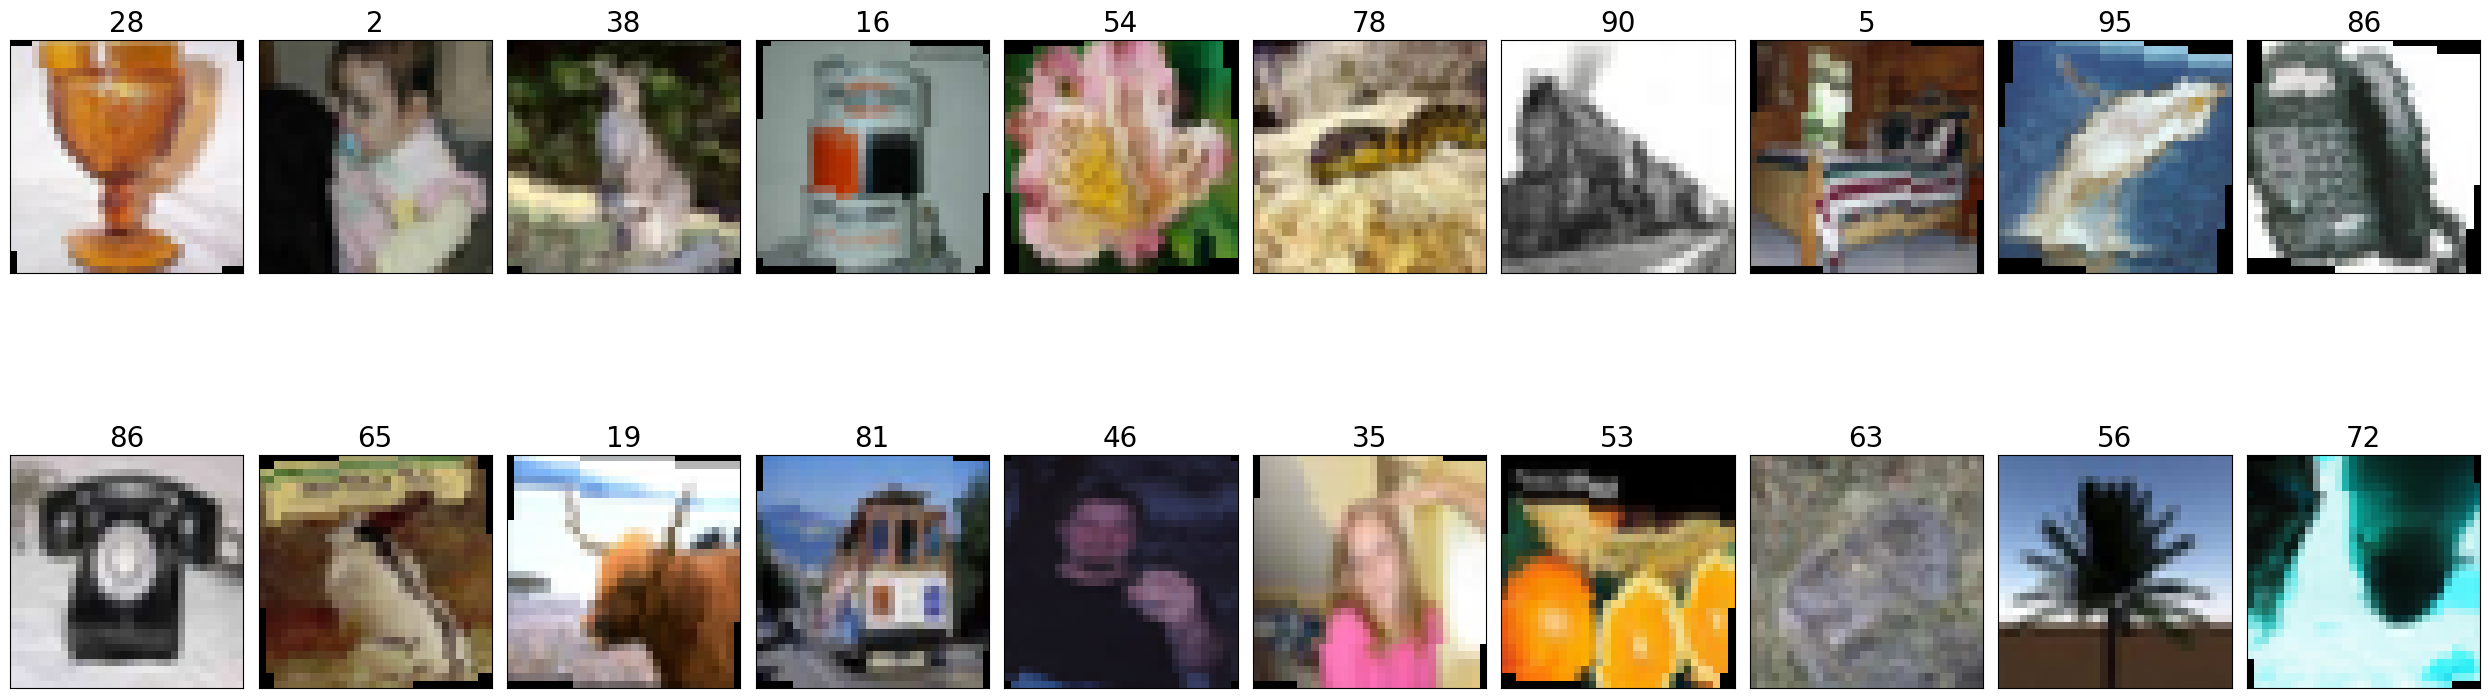

In [5]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

images = images / 2 + 0.5
images = torch.clamp(images, 0, 1)
images = images.numpy()


fig = plt.figure(figsize = (25, 10))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks = [], yticks = [])
    image = np.transpose(images[idx], (1, 2, 0))
    ax.imshow(image)
    ax.set_title(str(labels[idx].item()), fontsize = 20)

plt.tight_layout()
plt.show()

# Building The Network

In [6]:
def conv(channels_in, channels_out):
    return nn.Conv2d(channels_in, channels_out, kernel_size=3, stride=1, padding=1, bias=False)

def pool(channels_in):
    return nn.Conv2d(channels_in, channels_in, kernel_size=2, stride=2, bias=False)

def conv1x1(channels_in, channels_out):
    return nn.Conv2d(channels_in, channels_out, kernel_size=1, stride=1)

def bn(channels_in):
    return nn.BatchNorm2d(channels_in)

def relu():
    return nn.ReLU()

def dropout(rate):
    return nn.Dropout(rate)

In [7]:
class Layer(nn.Sequential):
    def __init__(self, channels):
        super(Layer, self).__init__()
        self.add_module('norm', bn(channels))
        self.add_module('relu', relu())
        self.add_module('conv', conv(channels, channels))

In [8]:
class ResBlock(nn.Module):
    def __init__(self, channels, number_of_layers):
        super(ResBlock, self).__init__()
        self.layers = nn.ModuleList([Layer(channels) for _ in range(number_of_layers)])

    def forward(self, input_data):
        residual = input_data
        for layer in self.layers:
            output = layer(input_data)
            input_data = output + residual
            residual = input_data
        return input_data

In [9]:
class Transition_Layer(nn.Sequential):
    def __init__(self, channels_in, channels_out):
        super(Transition_Layer, self).__init__()
        self.add_module('norm', bn(channels_in))
        self.add_module('relu', nn.ReLU())
        self.add_module('conv1x1', conv1x1(channels_in, channels_out))
        self.add_module('pool', pool(channels_out))
        self.add_module('dropout', dropout(0.3))

In [10]:
class stage(nn.Sequential):
    def __init__(self, channels_in, channels_out, number_of_layers):
        super(stage, self).__init__()
        self.add_module('res_block', ResBlock(channels_in, number_of_layers))
        self.add_module('transition_layer', Transition_Layer(channels_in, channels_out))

In [11]:
class ResNet(nn.Sequential):
    def __init__(self):
        super(ResNet, self).__init__()
        self.add_module('stage1', stage(3, 64, 15))
        self.add_module('stage2', stage(64, 128, 15))
        self.add_module('stage3', stage(128, 256, 15))
        self.add_module('stage4', stage(256, 512, 15))
        self.add_module('stage5', stage(512, 512, 15))
        self.add_module('res_block_final', ResBlock(512, 15))
        self.add_module('conv1x1', conv1x1(512, 100))
        self.add_module('flatten', nn.Flatten())

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
model = ResNet().to(device)

In [14]:
summary(model, input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                        Output Shape              Param #
ResNet                                        [128, 100]                --
├─stage: 1-1                                  [128, 64, 16, 16]         --
│    └─ResBlock: 2-1                          [128, 3, 32, 32]          --
│    │    └─ModuleList: 3-1                   --                        1,305
│    └─Transition_Layer: 2-2                  [128, 64, 16, 16]         --
│    │    └─BatchNorm2d: 3-2                  [128, 3, 32, 32]          6
│    │    └─ReLU: 3-3                         [128, 3, 32, 32]          --
│    │    └─Conv2d: 3-4                       [128, 64, 32, 32]         256
│    │    └─Conv2d: 3-5                       [128, 64, 16, 16]         16,384
│    │    └─Dropout: 3-6                      [128, 64, 16, 16]         --
├─stage: 1-2                                  [128, 128, 8, 8]          --
│    └─ResBlock: 2-3                          [128, 64, 16, 16]         --
│    │    └─M

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    model.parameters(),
    lr = learning_rate,
    weight_decay = 0.001
)

In [16]:
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for data, targets in tqdm(train_loader):
        data = data.to(device = device)
        targets = targets.to(device = device)

        scores = model(data)
        loss = criterion(scores, targets)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data, targets in val_loader:
            data = data.to(device = device)
            targets = targets.to(device = device)

            scores = model(data)
            loss = criterion(scores, targets)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
#     scheduler.step()

    print(f'Epoch: {epoch + 1}, Training Loss: {train_loss:.6f}, Validation Loss: {val_loss:.6f}')

100%|██████████| 352/352 [02:00<00:00,  2.93it/s]


Epoch: 1, Training Loss: 4.403253, Validation Loss: 4.396841


100%|██████████| 352/352 [02:09<00:00,  2.72it/s]


Epoch: 2, Training Loss: 4.067411, Validation Loss: 3.894733


100%|██████████| 352/352 [02:09<00:00,  2.71it/s]


Epoch: 3, Training Loss: 3.813174, Validation Loss: 3.734748


100%|██████████| 352/352 [02:09<00:00,  2.71it/s]


Epoch: 4, Training Loss: 3.564499, Validation Loss: 3.470068


100%|██████████| 352/352 [02:09<00:00,  2.72it/s]


Epoch: 5, Training Loss: 3.367573, Validation Loss: 3.665434


100%|██████████| 352/352 [02:05<00:00,  2.81it/s]


Epoch: 6, Training Loss: 3.196655, Validation Loss: 3.649161


100%|██████████| 352/352 [02:04<00:00,  2.84it/s]


Epoch: 7, Training Loss: 3.057717, Validation Loss: 3.322769


100%|██████████| 352/352 [02:04<00:00,  2.83it/s]


Epoch: 8, Training Loss: 2.945383, Validation Loss: 3.209172


100%|██████████| 352/352 [02:04<00:00,  2.83it/s]


Epoch: 9, Training Loss: 2.841646, Validation Loss: 3.094228


100%|██████████| 352/352 [02:04<00:00,  2.82it/s]


Epoch: 10, Training Loss: 2.759346, Validation Loss: 3.048476


100%|██████████| 352/352 [02:04<00:00,  2.83it/s]


Epoch: 11, Training Loss: 2.666903, Validation Loss: 2.809082


100%|██████████| 352/352 [02:03<00:00,  2.84it/s]


Epoch: 12, Training Loss: 2.604274, Validation Loss: 2.796165


100%|██████████| 352/352 [02:04<00:00,  2.83it/s]


Epoch: 13, Training Loss: 2.535815, Validation Loss: 2.775319


100%|██████████| 352/352 [02:04<00:00,  2.83it/s]


Epoch: 14, Training Loss: 2.470537, Validation Loss: 2.807661


100%|██████████| 352/352 [02:03<00:00,  2.84it/s]


Epoch: 15, Training Loss: 2.405609, Validation Loss: 2.867795


100%|██████████| 352/352 [02:04<00:00,  2.83it/s]


Epoch: 16, Training Loss: 2.340366, Validation Loss: 2.629420


100%|██████████| 352/352 [02:03<00:00,  2.84it/s]


Epoch: 17, Training Loss: 2.298557, Validation Loss: 2.556857


100%|██████████| 352/352 [02:04<00:00,  2.83it/s]


Epoch: 18, Training Loss: 2.248893, Validation Loss: 2.604218


100%|██████████| 352/352 [02:03<00:00,  2.84it/s]


Epoch: 19, Training Loss: 2.199723, Validation Loss: 2.432580


100%|██████████| 352/352 [02:04<00:00,  2.83it/s]


Epoch: 20, Training Loss: 2.154006, Validation Loss: 2.450020


100%|██████████| 352/352 [02:04<00:00,  2.83it/s]


Epoch: 21, Training Loss: 2.114245, Validation Loss: 2.384534


100%|██████████| 352/352 [02:04<00:00,  2.83it/s]


Epoch: 22, Training Loss: 2.068817, Validation Loss: 2.468438


100%|██████████| 352/352 [02:04<00:00,  2.83it/s]


Epoch: 23, Training Loss: 2.041983, Validation Loss: 2.509736


100%|██████████| 352/352 [02:04<00:00,  2.83it/s]


Epoch: 24, Training Loss: 1.998809, Validation Loss: 2.398192


100%|██████████| 352/352 [02:04<00:00,  2.84it/s]


Epoch: 25, Training Loss: 1.963508, Validation Loss: 2.473548


100%|██████████| 352/352 [02:04<00:00,  2.84it/s]


Epoch: 26, Training Loss: 1.925275, Validation Loss: 2.392764


100%|██████████| 352/352 [02:04<00:00,  2.84it/s]


Epoch: 27, Training Loss: 1.888616, Validation Loss: 2.179385


100%|██████████| 352/352 [02:04<00:00,  2.83it/s]


Epoch: 28, Training Loss: 1.868520, Validation Loss: 2.285676


100%|██████████| 352/352 [02:04<00:00,  2.84it/s]


Epoch: 29, Training Loss: 1.829474, Validation Loss: 2.268267


100%|██████████| 352/352 [02:04<00:00,  2.83it/s]


Epoch: 30, Training Loss: 1.813282, Validation Loss: 2.278343


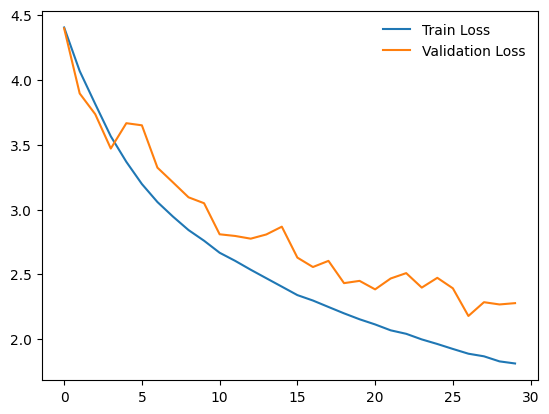

In [17]:
plt.plot(train_losses, label = 'Train Loss')
plt.plot(val_losses, label = 'Validation Loss')
plt.legend(frameon = False)

# Testing The Model

In [18]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device = device)
            y = y.to(device = device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)


    model.train()
    return num_correct/num_samples


print(f"Accuracy on Training set: {check_accuracy(train_loader, model) * 100:.2f}%")
print(f"Accuracy on Test set: {check_accuracy(test_loader, model) * 100:.2f}%")

Accuracy on Training set: 50.76%
Accuracy on Test set: 44.09%


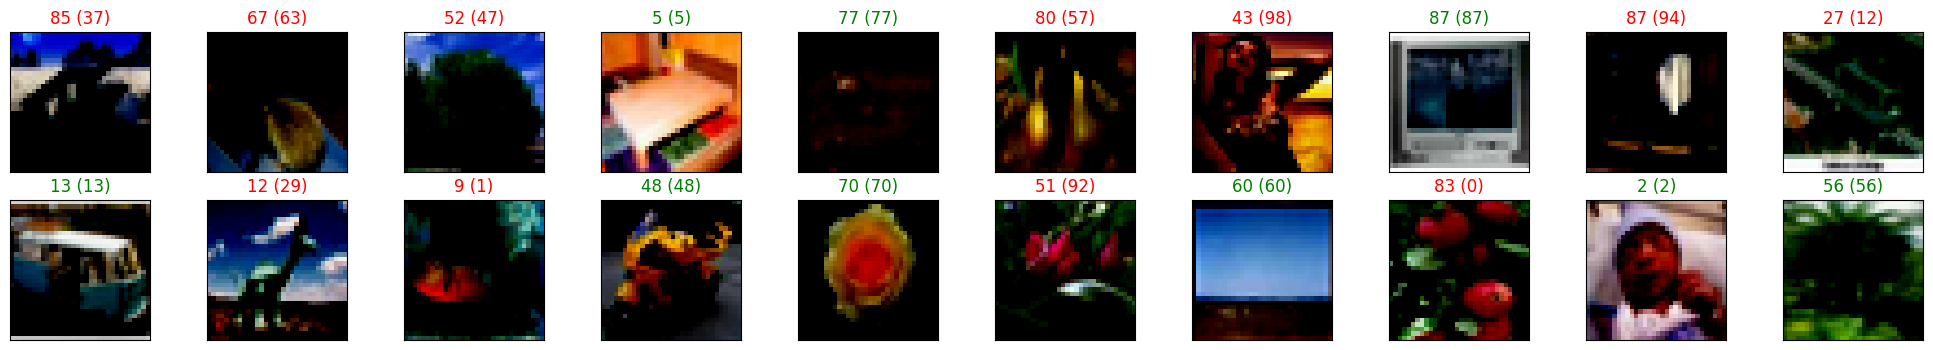

In [19]:
dataiter = iter(test_loader)
data, targets = next(dataiter)

data, targets = data.to(device), targets.to(device)

output = model(data)
_, preds = torch.max(output, 1)

data = data.cpu().numpy()
targets = targets.cpu().numpy()
preds = preds.cpu().numpy()

data = np.transpose(data, (0, 2, 3, 1))

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
    img = np.clip(data[idx], 0, 1)
    ax.imshow(img)
    ax.set_title("{} ({})".format(str(preds[idx]), str(targets[idx])),
                 color=("green" if preds[idx] == targets[idx] else "red"))
plt.show()